# 1. Выбор набора данных

In [2]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('student.csv', delimiter=',')

dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [106]:
# y = dataset['G3'] # final grade (numeric: from 0 to 20, output target)

# X = dataset[['sex', 'age', 'famsize', 'Pstatus', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc']]

y = dataset['Walc'] # weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

X = dataset[['sex', 'age', 'famsize', 'Pstatus', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout']]

dummies_sex = pd.get_dummies(X.sex)
dummies_famsize = pd.get_dummies(X.famsize)
dummies_Pstatus = pd.get_dummies(X.Pstatus)

X = pd.concat([X, dummies_sex, dummies_famsize, dummies_Pstatus], axis='columns')
X = X.drop(['sex', 'famsize', 'Pstatus'], axis='columns')

features = X.columns.values.tolist()
targets = pd.Series(y).unique()
targets = np.sort(targets)

print(features)
print(X.iloc[[0]].values)
print(targets)
print(y[0])


['age', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'F', 'M', 'GT3', 'LE3', 'A', 'T']
[[18  2  2  0  4  3  4  1  0  1  0  1  0]]
[1 2 3 4 5]
1


 - sex:

F - female

M - male

 - famsize:

GT3 - family size greater than 3

LE3 - family size less or equal to 3

 - Pstatus:

A - living together with parents

T - living apart from parents

# 2. Стандартизация и визуализация 

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_stand = scaler.fit_transform(X)
X_stand[0]

array([ 1.02788947,  0.65221024,  0.03560569, -0.40310574,  0.06878825,
       -0.19509888,  0.73251148,  0.87549841, -0.87549841,  0.64392092,
       -0.64392092,  2.76190137, -2.76190137])

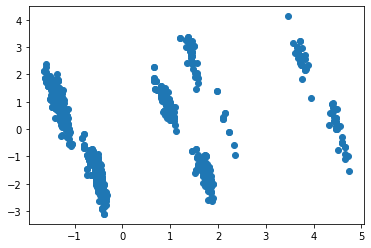

In [110]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_stand)
plt.scatter(X_trans[:,0], X_trans[:,1])
plt.show()

# 3. Обучение дерева решений без учителя


In [111]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score

n = len(X)
labels = range(0, n)
scores = []
for i in np.arange(0.05, 1, 0.05):
  model = DecisionTreeClassifier(criterion='entropy',
                                 min_impurity_decrease=i)
  model.fit(X, labels)
  labels = model.apply(X)
  sil = silhouette_score(X_stand, labels)
  scores.append({'param':round(i, 2),
                 'score':round(sil, 4)})
  
scores[:5]

[{'param': 0.05, 'score': -0.0204},
 {'param': 0.1, 'score': 0.0053},
 {'param': 0.15, 'score': -0.007},
 {'param': 0.2, 'score': 0.0118},
 {'param': 0.25, 'score': 0.0341}]

# 4. Визуализация зависимости silhouette score и silhoette score gain от min impurity decrease

In [112]:
scores[0]['diff'] = 0
for i, score in enumerate(scores):
  if i==0:
    continue
  score['diff'] = score['score'] - scores[i-1]['score']
scores[:5]

[{'param': 0.05, 'score': -0.0204, 'diff': 0},
 {'param': 0.1, 'score': 0.0053, 'diff': 0.0257},
 {'param': 0.15, 'score': -0.007, 'diff': -0.0123},
 {'param': 0.2, 'score': 0.0118, 'diff': 0.0188},
 {'param': 0.25, 'score': 0.0341, 'diff': 0.0223}]

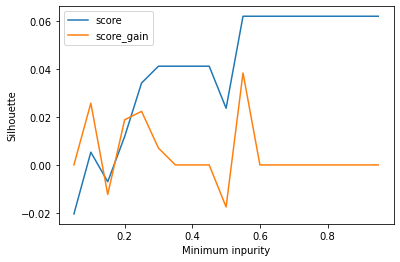

In [113]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in scores]
score_list = [x['score'] for x in scores]
diff_list = [x['diff'] for x in scores]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Silhouette')
ax.set_xlabel('Minimum inpurity')
plt.plot(param_list, score_list, label='score')
plt.plot(param_list, diff_list, label='score_gain')
ax.legend()
plt.show()

# 5. Визуализация обученного дерева решений

In [114]:
scores_sorted = sorted(scores, key=lambda x: x['diff'], reverse=True)
threshold = scores_sorted[0]['param']
print(threshold)

labels = range(0, n)
model = DecisionTreeClassifier(criterion='entropy',
                               min_impurity_decrease=threshold)
model.fit(X, labels)

0.55


DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.55)

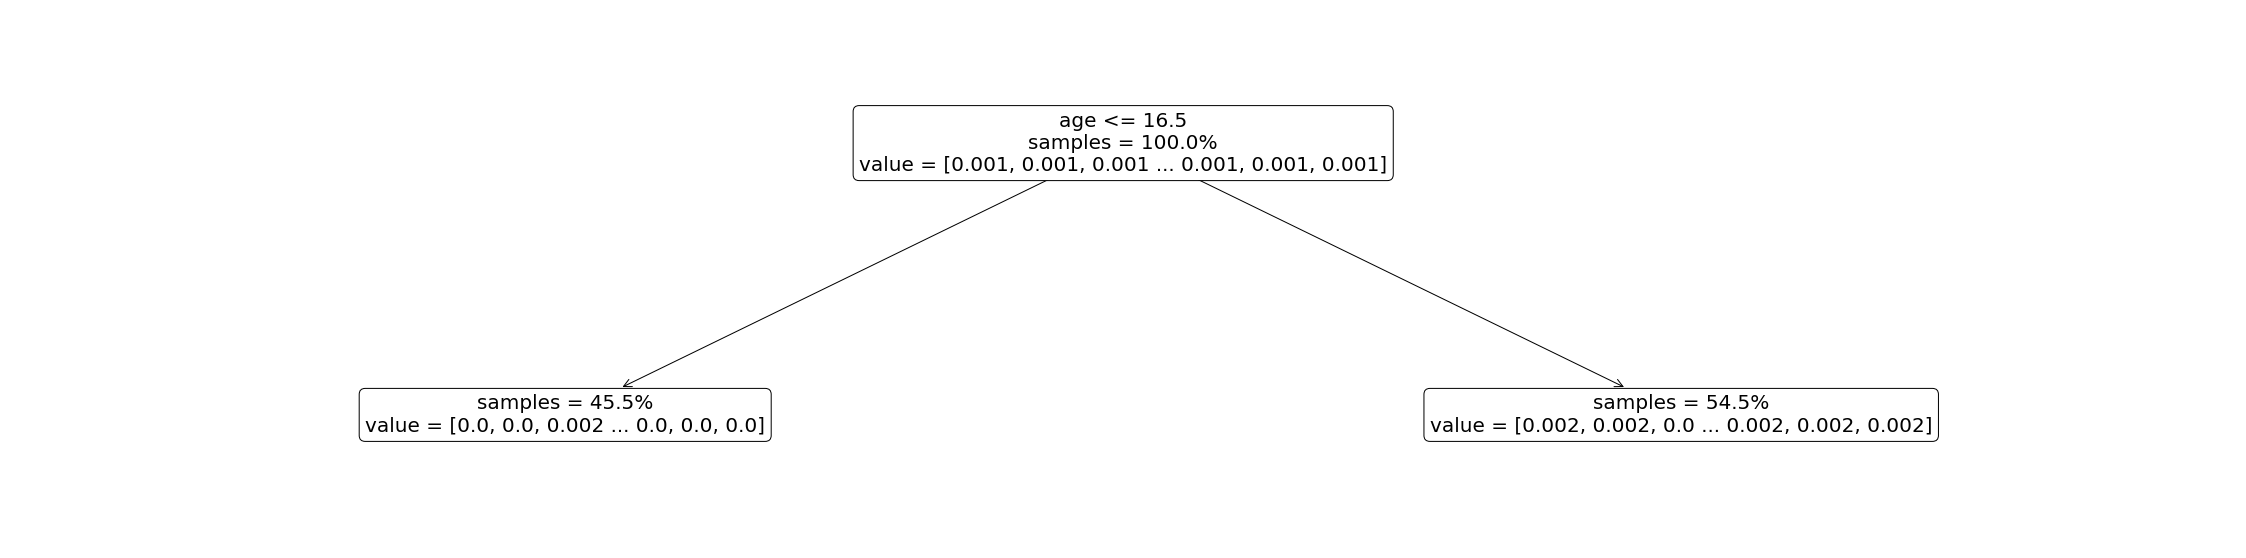

In [116]:
from sklearn import tree

fig = plt.figure(figsize=(40, 10))
tree.plot_tree(model,
               feature_names = X.columns,
               impurity=False,
               proportion=True,
               rounded=True,
               fontsize=20)
plt.show()

# 6. Конвертация дерева в онтологию

In [117]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
features = model.tree_.feature
thresholds = model.tree_.threshold

def make_node(i):
  node = {}
  node['parentID'] = i
  node['feature'] = X.columns[features[i]]
  node['threshold'] = round(thresholds[i], 2)
  return node

nodes = []
for i in range(0, n_nodes):
  if children_left[i] != -1:
    node = make_node(i)
    node['ID'] = children_left[i]
    node['comparison'] = '<='
    nodes.append(node)
  if children_right[i] != -1:
    node = make_node(i)
    node['ID'] = children_right[i]
    node['comparison'] = '>'
    nodes.append(node)

nodes[:5]

[{'parentID': 0,
  'feature': 'age',
  'threshold': 16.5,
  'ID': 1,
  'comparison': '<='},
 {'parentID': 0,
  'feature': 'age',
  'threshold': 16.5,
  'ID': 2,
  'comparison': '>'}]

In [118]:
!pip install owlready2
from owlready2 import *
import types

onto = get_ontology('onto.owl')

with onto:
  for feature in X.columns:
    onto_feature = types.new_class(feature, (DataProperty,))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.5 MB 1.2 MB/s 
  Created wheel for owlready2: filename=Owlready2-0.39-cp37-cp37m-linux_x86_64.whl size=22132076 sha256=27e3849770dfa132b86d1f8bf976102bd1111920d0a84e30fd17c20c240b7b82
  Stored in directory: /root/.cache/pip/wheels/c9/5b/fc/da1e42a17f22cd62bfb170f847a3fb541a7f628858ad3595ec
Successfully built owlready2


# 7.1. Создание классов

In [119]:
with onto:
  for node in nodes:
    parent = node['parentID']
    if parent == 0:
      onto_parent = Thing
    else:
      onto_parent = onto[f'Class_{parent}']
    onto_class = types.new_class(f'Class_{node["ID"]}', (onto_parent,))

    onto_feature = onto[node['feature']]
    threshold = node['threshold']
    if node['comparison'] == '<=':
      onto_class.equivalent_to.append(onto_feature.some(
          ConstrainedDatatype(float, max_inclusive = threshold)
      ))
    else:
      onto_class.equivalent_to.append(onto_feature.some(
          ConstrainedDatatype(float, min_inclusive = threshold)
      ))

onto.save('onto.owl', format='ntriples')

# 7.2. Создание экземпляров

In [124]:
print(len(X))

1044


In [125]:
for i in range(len(X)):
  with onto:
    row = X.loc[i]
    inst = Thing(f'inst{i}')
    for feature in X.columns:
      onto_feature = onto[feature]
      onto_feature[inst].append(round(float(row[feature]), 2))

# 8. Классификация экземпляров с помощью ризонера

In [126]:
with onto:
  sync_reasoner_pellet()
  print(inst.is_a)

onto.save('onto_classified.owl', format='ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-tdb-0.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-arq-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-runtime-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xercesImpl-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/log4j-1.2.16.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jgrapht-jdk1.5.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpcore-4.2.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xml-apis-1.4.01.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/local/lib/python3.7/dist-p

[onto.Class_2]


* Owlready * Reparenting onto.inst901: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst293: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst376: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst367: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst1032: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst653: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst313: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst331: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst738: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst892: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst239: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst996: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst910: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.inst316: {owl.Thing} => {onto.Class_2}
* Owlready * Reparenting onto.ins